In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from urllib.request import urlopen

from torchdiffeq import odeint_adjoint as odeint

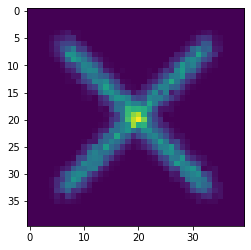

In [2]:
Z_DIM = 2
MAX_VAL = 4.0 # The image spans from -4 to +4 units in the x and y directions.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def make_image(n=10000):
    points = np.zeros((n, 2))
    points[:n//2,0] = np.linspace(-1,1,n//2)
    points[:n//2,1] = np.linspace(1,-1,n//2)
    points[n//2:,0] = np.linspace(1,-1,n//2)
    points[n//2:,1] = np.linspace(1,-1,n//2)
    np.random.seed(42)
    noise = np.clip(np.random.normal(scale=0.1, size=points.shape),-0.2,0.2)
    np.random.seed(None)
    points += noise
    img, _ = np.histogramdd(points, bins=40, range=[[-1.5,1.5],[-1.5,1.5]])
    return img

plt.imshow(make_image())
plt.show()

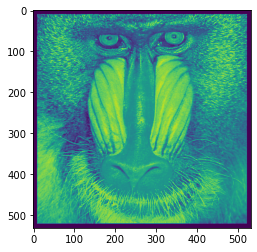

In [3]:
class ImageDataset():
    def __init__(self, img):
        h, w = img.shape
        xx = np.linspace(-MAX_VAL, MAX_VAL, w)
        yy = np.linspace(-MAX_VAL, MAX_VAL, h)
        xx, yy = np.meshgrid(xx, yy)
        xx = xx.reshape(-1, 1)
        yy = yy.reshape(-1, 1)
        self.means = np.concatenate([xx, yy], 1)
        self.probs = img.reshape(-1) / img.sum()
        self.noise_std = np.array([MAX_VAL/w, MAX_VAL/h])

    def sample(self, batch_size=512):
        inds = np.random.choice(int(self.probs.shape[0]), int(batch_size), p=self.probs)
        m = self.means[inds]
        samples = np.random.randn(*m.shape) * self.noise_std + m
        return torch.from_numpy(samples).type(torch.FloatTensor)

def read_image(url, pad=10):
    raw_img = np.array(Image.open(urlopen(url)).convert('L'))
    img = np.zeros((raw_img.shape[0] + (2 * pad), raw_img.shape[1] + (2 * pad)))
    img[pad:-pad, pad:-pad] = raw_img[:, :]
    return img

img = read_image('https://homepages.cae.wisc.edu/~ece533/images/baboon.png')
plt.imshow(img)
plt.show()

In [4]:
class ODEfunc(nn.Module):
    """
    Calculates time derivatives.

    torchdiffeq requires this to be a torch.nn.Module.
    """

    def __init__(self, hidden_dims=(64,64)):
        super(ODEfunc, self).__init__()
        # Define network layers.
        dim_list = [Z_DIM] + list(hidden_dims) + [Z_DIM]
        layers = []
        for dim_from, dim_to in zip(dim_list[:-1], dim_list[1:]):
            layers.append(nn.Linear(dim_from + 1, dim_to))
        self.layers = nn.ModuleList(layers)


    def get_z_dot(self, t, z):
        """z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
        z_dot = z
        for l, layer in enumerate(self.layers):
            # Concatenate t at each layer.
            tz_cat = torch.cat([t.expand(z.shape[0], 1), z_dot], dim=1)
            z_dot = layer(tz_cat)
            if l < len(self.layers) - 1:
                z_dot = F.softplus(z_dot)
        return z_dot


    def forward(self, t, states):
        """
        Calculate the time derivative of z and divergence.

        Parameters
        ----------
        t : torch.Tensor
            time
        state : tuple
            Contains two torch.Tensors: z and delta_logpz

        Returns
        -------
        z_dot : torch.Tensor
            Time derivative of z.
        negative_divergence : torch.Tensor
            Time derivative of the log determinant of the Jacobian.
        """
        z = states[0]
        with torch.set_grad_enabled(True):
            z.requires_grad_(True)
            t.requires_grad_(True)

            # Calculate the time derivative of z.
            # This is f(z(t), t; \theta) in Eq. 4.
            z_dot = self.get_z_dot(t, z)

            # Calculate the time derivative of the log determinant of the
            # Jacobian.
            # This is -Tr(\partial z_dot / \partial z(t)) in Eq.s 2-4.
            #
            # Note that this is the brute force, O(D^2), method. This is fine
            # for D=2, but the authors suggest using a Monte-carlo estimate
            # of the trace (Hutchinson's trace estimator, eq. 7) for a linear
            # time estimate in larger dimensions.
            divergence = 0.0
            for i in range(z.shape[1]):
                divergence += \
                        torch.autograd.grad( \
                            z_dot[:, i].sum(), z, create_graph=True \
                        )[0][:, i]

        return z_dot, -divergence.view(z.shape[0], 1)


In [5]:
def _flip(x, dim):
    indices = [slice(None)] * x.dim()
    indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long, device=x.device)
    return x[tuple(indices)]


class FfjordModel(torch.nn.Module):
    """Continuous noramlizing flow model."""

    def __init__(self):
        super(FfjordModel, self).__init__()
        self.time_deriv_func = ODEfunc()

    def forward(self, z, delta_logpz=None, integration_times=None, reverse=False):
        """
        Implementation of Eq. 4.

        We want to integrate both f and the trace term. During training, we
        integrate from t_1 (data distribution) to t_0 (base distibution).

        Parameters
        ----------
        z : torch.Tensor
            Samples.
        delta_logpz : torch.Tensor
            Log determininant of the Jacobian.
        integration_times : torch.Tensor
            Which times to evaluate at.
        reverse : bool, optional
            Whether to reverse the integration times.

        Returns
        -------
        z : torch.Tensor
            Updated samples.
        delta_logpz : torch.Tensor
            Updated log determinant term.
        """
        if delta_logpz is None:
            delta_logpz = torch.zeros(z.shape[0], 1).to(device)
        if integration_times is None:
            integration_times = torch.tensor([0.0, 1.0]).to(z)
        if reverse:
            integration_times = _flip(integration_times, 0)

        # Integrate. This is the call to torchdiffeq.
        state = odeint(
            self.time_deriv_func, # Calculates time derivatives.
            (z, delta_logpz), # Values to update.
            integration_times, # When to evaluate.
            method='dopri5', # Runge-Kutta
        )

        if len(integration_times) == 2:
            state = tuple(s[1] for s in state)
        z, delta_logpz = state
        return z, delta_logpz


In [6]:
def save_trajectory(model, savedir='imgs', ntimes=101, memory=0.01, n=4000):
    """
    Plot the dynamics of the learned ODE.

    Saves images to `savedir`.

    Parameters
    ----------
    model : FfjordModel
        Model defining the dynamics.
    savedir : str, optional
        Where to save output.
    ntimes : int, optional
        Number of timesteps to visualize.
    memory : float
        Controls how finely the density grid is sampled.
    n : int, optional
        Number of samples to visualize.
    """
    model.eval()

    # Sample from prior
    z_samples = torch.randn(n, 2).to(device)

    # Sample from a grid.
    npts = 800
    side = np.linspace(-MAX_VAL, MAX_VAL, npts)
    xx, yy = np.meshgrid(side, side)
    xx = torch.from_numpy(xx).type(torch.float32).to(device)
    yy = torch.from_numpy(yy).type(torch.float32).to(device)
    z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], 1)

    with torch.no_grad():
        logp_samples = standard_normal_logprob(z_samples)
        logp_grid = standard_normal_logprob(z_grid)
        integration_times = torch.linspace(0, 1.0, ntimes).to(device)

        z_traj, _ = model(z_samples, logp_samples, integration_times=integration_times, reverse=True)
        z_traj = z_traj.cpu().numpy()

        grid_z_traj, grid_logpz_traj = [], []
        inds = torch.arange(0, z_grid.shape[0]).to(torch.int64)
        for ii in torch.split(inds, int(z_grid.shape[0] * memory)):
            # Batched evaluation of transformation.
            _grid_z_traj, _grid_logpz_traj = \
                    model(z_grid[ii], logp_grid[ii], \
                    integration_times=integration_times, reverse=True)
            _grid_z_traj, _grid_logpz_traj = \
                    _grid_z_traj.cpu().numpy(), _grid_logpz_traj.cpu().numpy()
            grid_z_traj.append(_grid_z_traj)
            grid_logpz_traj.append(_grid_logpz_traj)
        grid_z_traj = np.concatenate(grid_z_traj, axis=1)
        grid_logpz_traj = np.concatenate(grid_logpz_traj, axis=1)

        if not os.path.exists(savedir):
            os.makedirs(savedir)
        plt.figure(figsize=(8, 4))
        ax_range = [[-MAX_VAL, MAX_VAL], [-MAX_VAL, MAX_VAL]]
        # For each time...
        for t in range(z_traj.shape[0]):
            plt.clf()
            ax = plt.subplot(1, 2, 2, aspect="equal")

            # Plot the samples.
            ax = plt.subplot(1, 2, 1, aspect="equal")
            zk = z_traj[t]
            ax.hist2d(zk[:, 0], zk[:, 1], range=ax_range, bins=200)
            ax.invert_yaxis()
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.set_title("Samples", fontsize=24)

            # Plot the density.
            ax = plt.subplot(1, 2, 2)
            z, logqz = grid_z_traj[t], grid_logpz_traj[t]
            xx = z[:, 0].reshape(npts, npts)
            yy = z[:, 1].reshape(npts, npts)
            qz = np.exp(logqz).reshape(npts, npts)
            plt.pcolormesh(xx, yy, qz)
            ax.set_xlim(-MAX_VAL, MAX_VAL)
            ax.set_ylim(-MAX_VAL, MAX_VAL)
            cmap = matplotlib.cm.get_cmap(None)
            ax.set_facecolor(cmap(0.))
            ax.invert_yaxis()
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.set_title("Density", fontsize=24)

            # Save the figure.
            plt.savefig(os.path.join(savedir, f"viz-{t:05d}.jpg"))



def trajectory_to_video(savedir='imgs', mp4_fn='transform.mp4'):
    """Save the images written by `save_trajectory` as an mp4."""
    import subprocess
    img_fns = os.path.join(savedir, 'viz-%05d.jpg')
    video_fn = os.path.join(savedir, mp4_fn)
    bashCommand = 'ffmpeg -y -i {} {}'.format(img_fns, video_fn)
    process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()


def standard_normal_logprob(z):
    """2d standard normal, sum over the second dimension."""
    return (-np.log(2 * np.pi) - 0.5 * z.pow(2)).sum(1, keepdim=True)



In [13]:
image_url = None

In [14]:
# Define a distribution we can sample from.
if image_url is None:
    img = make_image()
else: 
    img = read_image(image_url)


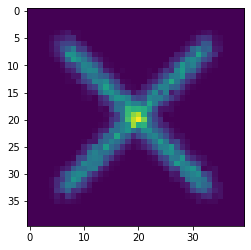

In [15]:
# Plot the target image.
plt.imshow(img)
plt.show()


In [16]:
# Make a dataset to draw samples from an image-defined distribution.
dset = ImageDataset(img=img)

# Define the model.
model = FfjordModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.train();

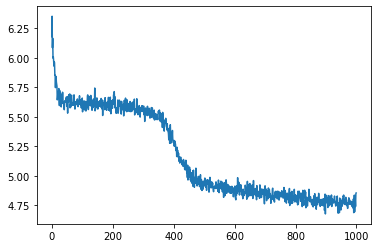

In [17]:
from tqdm.auto import tqdm
from IPython.display import clear_output

losses = []

for iteration in tqdm(range(1000), position=0, leave=False):
    optimizer.zero_grad()

    # Sample from the image distribution.
    z_t1 = dset.sample(512).to(device)

    # Transform to the image samples to base distribution samples.
    z_t0, delta_logpz = model(z_t1)

    # Calculate a loss: Eq. 3
    # Log likelihood of the base distribution samples.
    logpz_t0 = standard_normal_logprob(z_t0)
    
    # Subtract the correction term (log determinant of the Jacobian). Note
    # that we integrated from t_1 to t_0 and integrated a negative trace
    # term, so the signs align with Eq. 3.
    logpz_t1 = logpz_t0 - delta_logpz
    loss = -torch.mean(logpz_t1)
    
    # Take an optimization step.
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (iteration + 1) % 100 == 0:
        clear_output()
        plt.plot(losses)
        plt.show()


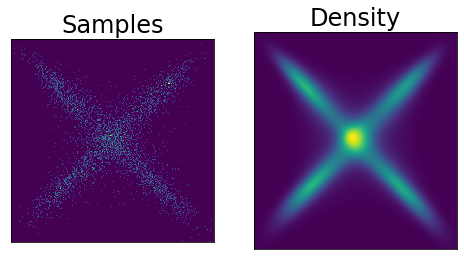

In [18]:
# Plot the results.
save_trajectory(model, ntimes=101)
trajectory_to_video()
